In [ ]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import BaseDLV3
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random
from ModelInfer import ModelInfer

In [2]:
!nvidia-smi

Sat Apr  6 21:13:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   29C    P0             43W /  300W |       0MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!export CUDA_VISIBLE_DEVICES=1

In [4]:
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
test_set = Balltest("ellipse/uniform_samples_80.json")
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([3]), tensor([4]))

Text(0.5, 1.0, 'First Frame in test set')

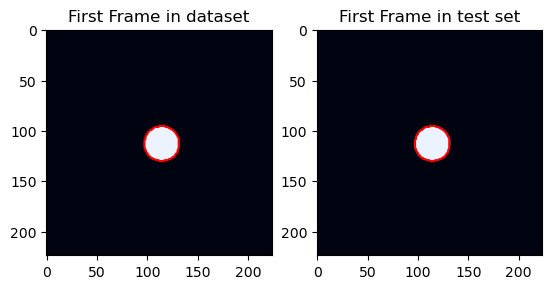

In [6]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

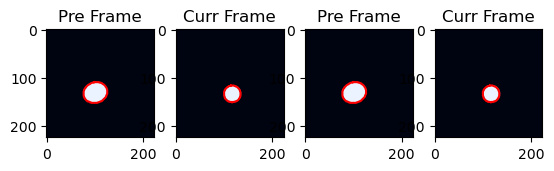

In [7]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [8]:
model = BaseDLV3()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/pytorch_vision_v0.10.0
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_hea

In [9]:
model = model.cuda()
results = model(
    first_frame.cuda(),
    first_boundary.cuda(),
    pre_frame.cuda(),
    curr_frame.cuda(),
    pre_boundary.cuda(),
)

In [10]:
order_loss(results[-1], curr_boundary.cuda())

tensor(20.2177, device='cuda:0', grad_fn=<DivBackward0>)

In [11]:
test_set = Balltest("ellipse/uniform_samples_80.json")

In [12]:
model_infer = ModelInfer(test_set)

In [13]:
model_infer.infer_model(model)

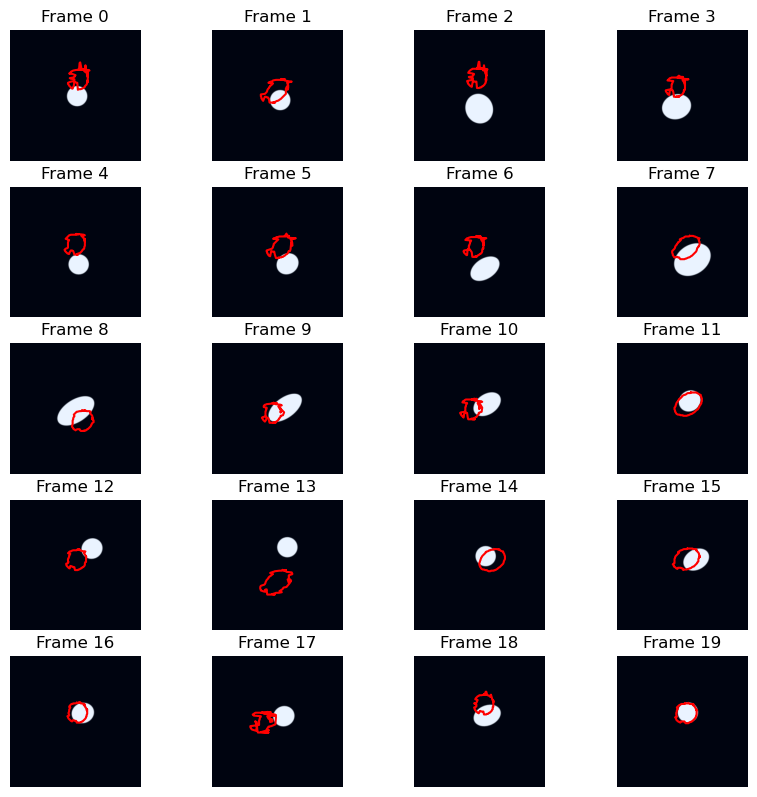

In [14]:
plt.figure(figsize=(10, 20))
for i in range(len(test_set)):
    plt.subplot(10, 4, i + 1)
    img, sgm, boundary = test_set[i]
    plt.imshow(normalize_image(img.permute(1, 2, 0)))
    boundary = model_infer.get_boundary(i)
    plt.plot(boundary.cpu()[:, 0], boundary.cpu()[:, 1], "r")
    plt.axis("off")
    plt.title(f"Frame {i}")

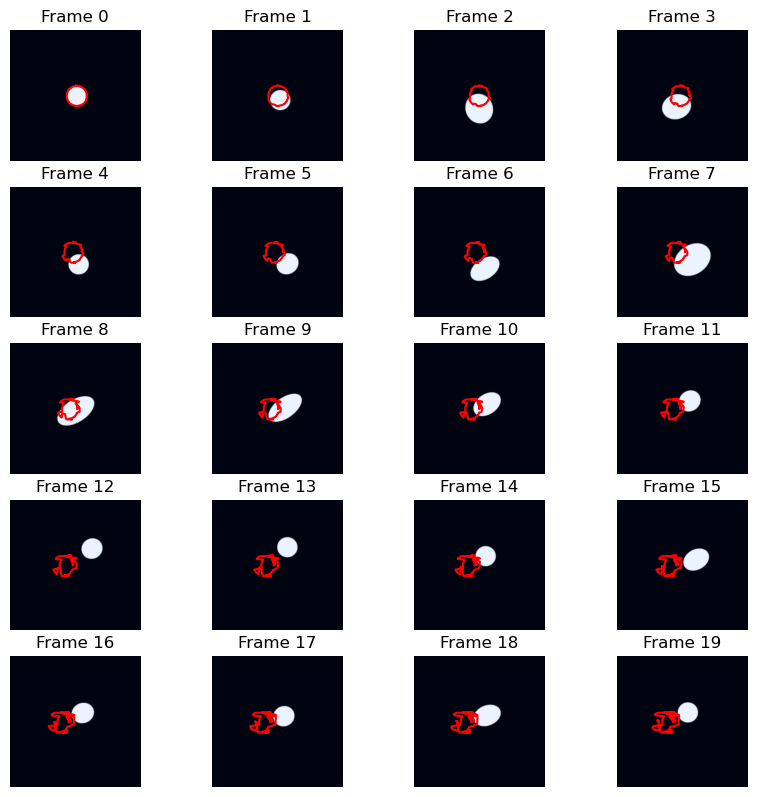

0.15853689300569834

In [15]:
model_infer.show_infer_result(0)

In [16]:
model = BaseDLV3().to("cuda")
model_infer = ModelInfer(test_set)
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/pytorch_vision_v0.10.0


In [17]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
interval_num = 155
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
test_set = Balltest("ellipse/uniform_samples_80.json")
model_infer = ModelInfer(test_set)
epoch_index = 0

Epoch 1, Loss: 40.15
Epoch 2, Loss: 37.87
Epoch 3, Loss: 37.54
Epoch 4, Loss: 37.07
Epoch 5, Loss: 36.77
Epoch 6, Loss: 36.82
Epoch 7, Loss: 36.77
Epoch 8, Loss: 36.85
Epoch 9, Loss: 37.43
Epoch 10, Loss: 36.50
Epoch 11, Loss: 37.60
Epoch 12, Loss: 36.78
Epoch 13, Loss: 37.03
Epoch 14, Loss: 37.48
Epoch 15, Loss: 36.35
Epoch 16, Loss: 36.77
Epoch 17, Loss: 36.57
Epoch 18, Loss: 36.37
Epoch 19, Loss: 36.66
Epoch 20, Loss: 36.53
Epoch 21, Loss: 36.26
Epoch 22, Loss: 36.55
Epoch 23, Loss: 36.44
Epoch 24, Loss: 36.71
Epoch 25, Loss: 36.59
Epoch 26, Loss: 36.57
Epoch 27, Loss: 36.02
Epoch 28, Loss: 36.12
Epoch 29, Loss: 36.47
Epoch 30, Loss: 38.17
Epoch 31, Loss: 36.57
Epoch 32, Loss: 36.96
Epoch 33, Loss: 36.53
Epoch 34, Loss: 36.44
Epoch 35, Loss: 36.34
Epoch 36, Loss: 36.42
Epoch 37, Loss: 36.45
Epoch 38, Loss: 36.30
Epoch 39, Loss: 36.43
Epoch 40, Loss: 36.26
Epoch 41, Loss: 36.66
Epoch 42, Loss: 36.52
Epoch 43, Loss: 36.50
Epoch 44, Loss: 36.51
Epoch 45, Loss: 36.60
Epoch 46, Loss: 36.

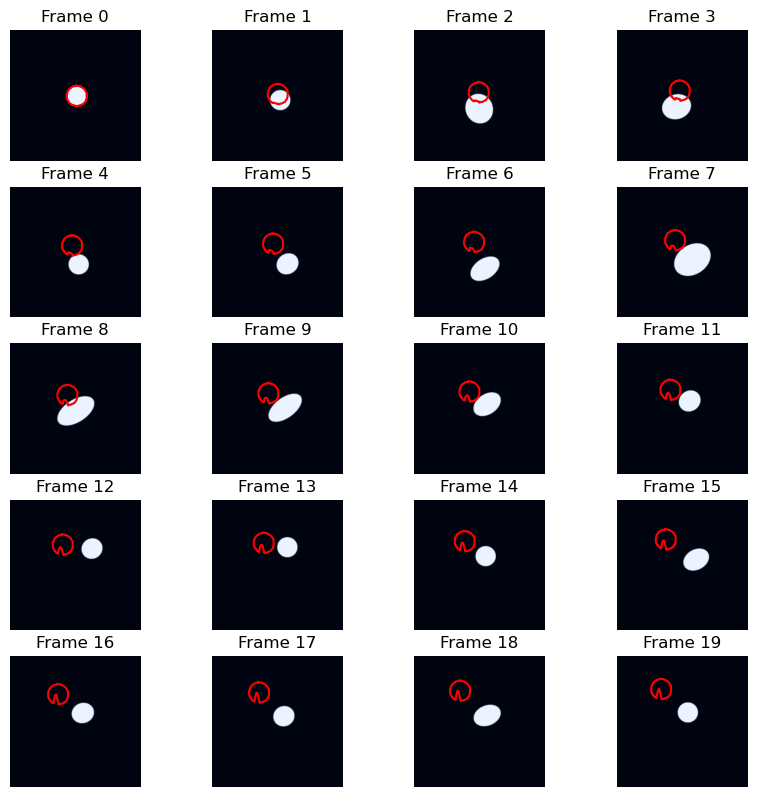

Epoch 50, IOU: 0.086008
Epoch 51, Loss: 113.33
Epoch 52, Loss: 78.73
Epoch 53, Loss: 73.87
Epoch 54, Loss: 71.92
Epoch 55, Loss: 85.18
Epoch 56, Loss: 87.99
Epoch 57, Loss: 83.56
Epoch 58, Loss: 96.33
Epoch 59, Loss: 105.00
Epoch 60, Loss: 87.74
Epoch 61, Loss: 85.78
Epoch 62, Loss: 92.35
Epoch 63, Loss: 95.43
Epoch 64, Loss: 95.91
Epoch 65, Loss: 84.96
Epoch 66, Loss: 90.17
Epoch 67, Loss: 90.67
Epoch 68, Loss: 64.11
Epoch 69, Loss: 93.50
Epoch 70, Loss: 75.40
Epoch 71, Loss: 77.70
Epoch 72, Loss: 79.59
Epoch 73, Loss: 99.66
Epoch 74, Loss: 104.41
Epoch 75, Loss: 100.43
Epoch 76, Loss: 74.80
Epoch 77, Loss: 95.46
Epoch 78, Loss: 76.54
Epoch 79, Loss: 77.75
Epoch 80, Loss: 95.83
Epoch 81, Loss: 95.56
Epoch 82, Loss: 85.35
Epoch 83, Loss: 92.51
Epoch 84, Loss: 77.96
Epoch 85, Loss: 103.64
Epoch 86, Loss: 88.31
Epoch 87, Loss: 107.65
Epoch 88, Loss: 98.24
Epoch 89, Loss: 92.76
Epoch 90, Loss: 72.95
Epoch 91, Loss: 101.87
Epoch 92, Loss: 71.37
Epoch 93, Loss: 87.91
Epoch 94, Loss: 90.48
E

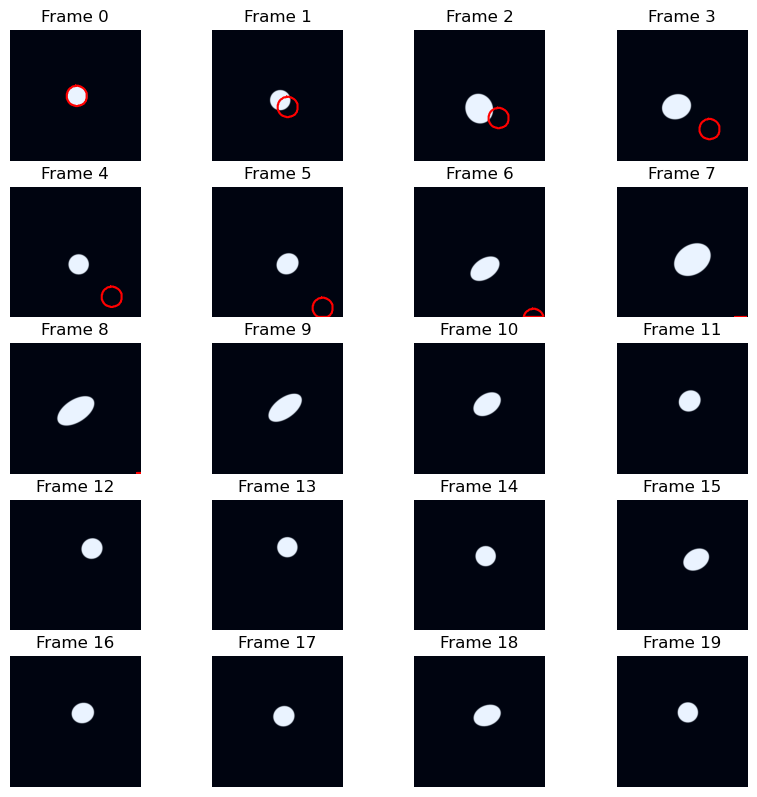

Epoch 95, IOU: 0.063210
Epoch 96, Loss: 385.58
Epoch 97, Loss: 341.93
Epoch 98, Loss: 214.67
Epoch 99, Loss: 212.26
Epoch 100, Loss: 196.14
Epoch 101, Loss: 192.70
Epoch 102, Loss: 189.32
Epoch 103, Loss: 194.67
Epoch 104, Loss: 199.15
Epoch 105, Loss: 181.70
Epoch 106, Loss: 200.11
Epoch 107, Loss: 206.01
Epoch 108, Loss: 200.24
Epoch 109, Loss: 212.55
Epoch 110, Loss: 193.45
Epoch 111, Loss: 198.80
Epoch 112, Loss: 186.24
Epoch 113, Loss: 192.93
Epoch 114, Loss: 204.32
Epoch 115, Loss: 209.82
Epoch 116, Loss: 196.32
Epoch 117, Loss: 188.32
Epoch 118, Loss: 191.13
Epoch 119, Loss: 201.51
Epoch 120, Loss: 197.09
Epoch 121, Loss: 189.90
Epoch 122, Loss: 190.87
Epoch 123, Loss: 184.64
Epoch 124, Loss: 212.18


KeyboardInterrupt: 

In [18]:
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
            pre_idx = pre_idx.item()
            curr_idx = curr_idx.item()
            pre_boundary = model_infer.get_boundary(pre_idx)
            pre_boundary = pre_boundary.unsqueeze(0).to("cuda")
            first_boundary = first_boundary.to("cuda")
            first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
                first_frame.to("cuda"),
                first_boundary.to("cuda"),
                pre_frame.to("cuda"),
                curr_frame.to("cuda"),
                pre_boundary.to("cuda"),
                curr_boundary.to("cuda"),
            )
            optimizer.zero_grad()
            results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
            mean_loss += loss.item()
            # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            loss.backward()
            optimizer.step()
        mean_loss /= len(data_loader)
        epoch_index += 1
        print(f"Epoch {epoch_index}, Loss: {mean_loss:.2f}")
        dict_loss[epoch_index] = mean_loss
    model_infer.infer_model(model)
    iou = model_infer.show_infer_result(0)
    dict_iou[epoch_index] = iou
    print(f"Epoch {epoch_index}, IOU: {iou:5f}")
    if interval_epochs > 100:
        interval_epochs = 50
    elif interval_epochs > 5:
        interval_epochs -= 5

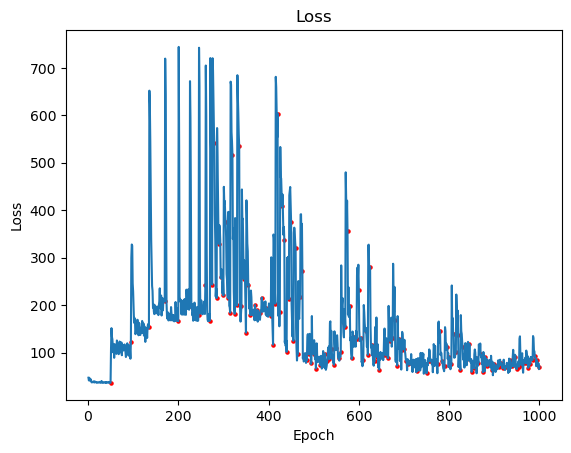

In [ ]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(list(dict_iou.keys()), [dict_loss[i] for i in list(dict_iou.keys())], c="r", s=5)
plt.title("Loss")
plt.show()

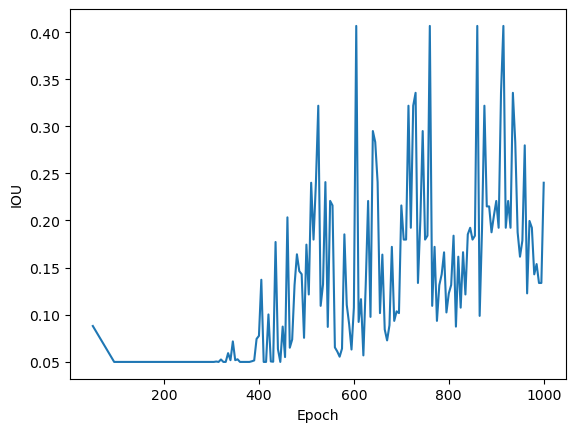

In [ ]:
# plot the iou
plt.plot(list(dict_iou.keys()), list(dict_iou.values()))
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()